In [1]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from add_features import medication_score, add_tweet_info
import eli5



### Importação dos datasets

- `df_train`: dataset de treino
- `df_test`: dataset de teste

In [2]:
df_train = pd.read_csv('task1_training.csv', delimiter = '\t')
df_test = pd.read_csv('task1_testing.csv', delimiter = '\t')


In [3]:
print(len(df_train))
print(len(df_test))

55419
13853


In [4]:
print(df_train['class'].value_counts())
print()
print(df_test['label'].value_counts())


class
0    55273
1      146
Name: count, dtype: int64

label
0    13817
1       36
Name: count, dtype: int64


### Pré processamento do texto

Processamento básico:

- minúsculas
- remover urls
- remover usernames
- remover pontuaçao repetida (exemplo: 'YES!!!' -> 'YES!')
- separar pontuação
- remover símbolos •‘’“”
- remover &amp &lt &gt
- remover #

In [5]:
from process import BasicPreprocessor

processing = BasicPreprocessor()
processing.preprocess(df_train, 'tweet')
processing.preprocess(df_test, 'tweet')

#### Tokenization + lemmatization

In [6]:
def lemma_tokenizer(text):
    res = list()

    #criar tokens
    tokens = word_tokenize(text)

    #lemmatizer
    lemmatizer = WordNetLemmatizer()
    for token in tokens:
        res.append(lemmatizer.lemmatize(token))
    return res


df_train['tweet'] = df_train['tweet'].apply(lemma_tokenizer)
df_test['tweet'] = df_test['tweet'].apply(lemma_tokenizer)

#### Remoçao de stopwords

In [7]:
#remove stopwords
def remove_stopwords(original_sentence):
    stop_words = set(stopwords.words('english'))
    filtered_sentence = list()

    for word in original_sentence:
        if word not in stop_words:
            filtered_sentence.append(word)

    return filtered_sentence
    

df_train['tweet'] = df_train['tweet'].apply(remove_stopwords)
df_test['tweet'] = df_test['tweet'].apply(remove_stopwords)

### Geração de novas features

Serão acrescentadas posteriormente à matriz do tfidf

In [8]:
medication_score(df_train,'medication_list.txt')
medication_score(df_test,'medication_list.txt')


,tweet_id,user_id,tweet,created_at,label,medication_score
0,502548414362841091,445019339,"[caydens, already, starting, open, eye, !, ane...",2014-08-21,0,0
1,557183572713676800,1485346748,"[johnny, cash, kind, mornin]",2015-01-19,0,0
2,442493939493261313,285855751,[chest],2014-03-09,0,0
3,499670327299805186,2421157857,"[sumn, slight]",2014-08-13,0,0
4,667265159753170944,1087305673,"[never, ever, excited, see, adelanto, .]",2015-11-19,0,0
...,...,...,...,...,...,...
13848,765601444678475778,1143892999,[go],2016-08-16,0,0
13849,821462917086183425,4745862650,"[jamie, foxx, movie, wa, coo, ,, see, relation...",2017-01-17,0,0
13850,870832539094491136,429115374,"[always, protect, son, ,, ill, damned, anyone,...",2017-06-03,0,0
13851,648522498984816640,1465089974,"[baby, kicking, strong, past, day, adriene, fi...",2015-09-28,0,0


In [9]:
type(df_train['medication_score'])
type(df_test['medication_score'])

pandas.core.series.Series

### TF-IDF

In [10]:
#criaçao de X_train, y_train, X_test, y_test

X_train = df_train['tweet']
y_train = df_train['class']

X_test = df_test['tweet']
y_test = df_test['label']

In [11]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (55419,)
X_test shape:  (13853,)
y_train shape:  (55419,)
y_test shape:  (13853,)


In [12]:
#mindf e maxdf
#tweet tokenizer - nltk
#cross_val_score no sklear.model_selection
#hyperparameters
#gridsearchCV

#rf, nb, logistic regression, multilayer perception

In [13]:
def dummy_tokenizer(text):
    return text

In [14]:
# pipeline = Pipeline([
#     ('tfidf', TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)),       # Step 1: Apply TF-IDF vectorization
#     ('select_percentile', SelectPercentile(percentile=50))  # Step 2: Select top 50% features
# ])

In [15]:
tfidf = TfidfVectorizer(tokenizer= dummy_tokenizer, stop_words='english', lowercase=False)  

In [16]:
tfidf

TfidfVectorizer(lowercase=False, stop_words='english',
                tokenizer=<function dummy_tokenizer at 0x00000276F9914DC0>)

In [17]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = tfidf.transform(X_test)


c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


#### Adicionar medication_scores ao tfidf

In [18]:
import scipy as sp
#add medication score
new_train = [[x] for x in df_train['medication_score'].tolist()]
new_test = [[x] for x in df_test['medication_score'].tolist()]

X_train_tfidf = sp.sparse.hstack((X_train_tfidf, new_train))
X_test_tfidf = sp.sparse.hstack((X_test_tfidf, new_test))

In [19]:
for i in tfidf.get_feature_names_out():
    print(i)

!
#
$
%
&
(
)
*
+
+=++=
+a
+hello
+pound
+tax
+week
+win
+yrs
,
.
..
...
.a
.already
.am
.and
.andand
.as
.before
.bg
.but
.by
.colt
.drink
.enter
.even
.everything
.except
.exhausting
.expecting
.farm
.followers
.going
.have
.hm
.i
.in
.iphone
.it
.its
.knowing
.leaves
.linkin
.little
.many
.menor
.milf
.mini
.my
.nah
.needs
.ninja
.no
.nobody
.not
.obviously
.ok
.oops
.or
.org
.our
.pages
.place
.pretty
.quickly
.realms
.reminding
.rock
.s
.she
.since
.so
.some
.something
.still
.stuff
.that
.the
.they
.to
.too
.uh
.uhh
.upon
.watching
.we
.well
.what
.why
.with
.without
.wtf
.yay
.yes
.you
.yup
/
:
:lisa
:looks
;
<
=
=overstimulated
>
?
@
[
\
]
^
^^
^^^^
^he
a++++
a.
a.surprise
aa
aab
aahaha
aaliyah
aandd
aande
aandm
aandp
aandw
aargh
aaron
aaw
aaye
ab
abandon
abandoned
abbey
abbi
abbreviates
abbreviating
abbreviation
abby
abc
abcmouse
abdomen
abdominal
abduction
abear
abed
abel
abfab
abh
abigail
abigale
ability
abit
able
abnormal
abolished
abolishes
abort
aborted
abortion
abou
abou

### SVM

In [20]:
clf_svm = LinearSVC()
clf_svm.fit(X_train_tfidf, y_train)
y_pred_svm = clf_svm.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_svm))


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.50      0.67        36

    accuracy                           1.00     13853
   macro avg       1.00      0.75      0.83     13853
weighted avg       1.00      1.00      1.00     13853



In [21]:
from sklearn.metrics import make_scorer, f1_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
my_f1_scorer = make_scorer(f1_score, pos_label = 1)
scores_f1 = cross_val_score(clf_svm, X_train_tfidf, y_train, scoring = my_f1_scorer, cv = skf)
print(scores_f1)
print(scores_f1.mean())

[0.59090909 0.61904762 0.55813953 0.59090909 0.5       ]
0.5718010671499043


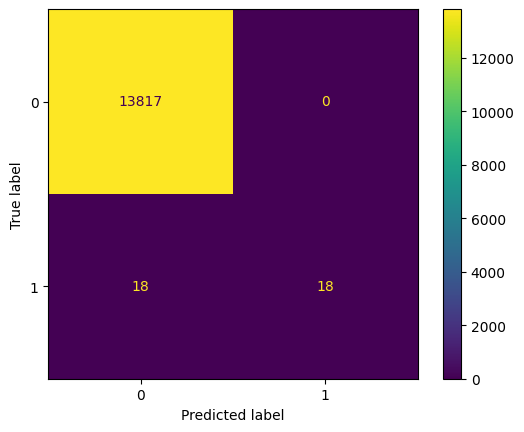

In [22]:
cm = confusion_matrix(y_test, y_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_svm.classes_)
disp.plot()

### Random forest

In [23]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_tfidf, y_train)
y_pred_rf = clf_rf.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_rf))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       1.00      0.25      0.40        36

    accuracy                           1.00     13853
   macro avg       1.00      0.62      0.70     13853
weighted avg       1.00      1.00      1.00     13853



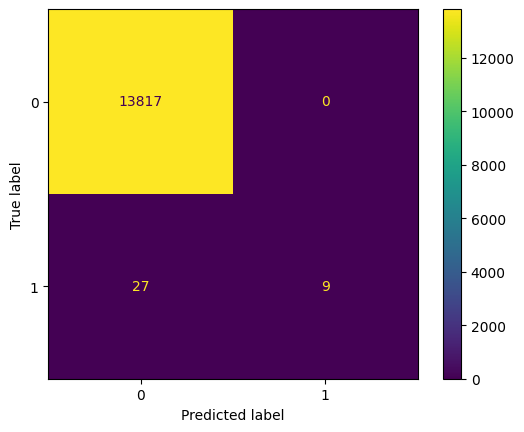

In [24]:
cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
disp.plot()

### Logistic Regression

In [25]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_tfidf, y_train)
y_pred_lr = clf_lr.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_lr))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.93      0.39      0.55        36

    accuracy                           1.00     13853
   macro avg       0.97      0.69      0.77     13853
weighted avg       1.00      1.00      1.00     13853



In [26]:
from sklearn.metrics import make_scorer, f1_score
my_f1_scorer = make_scorer(f1_score, pos_label = 1)
scores_f1 = cross_val_score(clf_lr, X_train_tfidf, y_train, scoring = my_f1_scorer, cv = 6)
print(scores_f1)
print(scores_f1.mean())

[0.55       0.4375     0.4        0.55555556 0.4        0.4516129 ]
0.4657780764635604


In [27]:
print("Valores previstos: ", list(y_pred_lr))
print("Valores reais: " , list(y_test))
score = 0
for x,y in zip(list(y_pred_lr), list(y_test)):
    score +=1
    if x != y:
        print(score)

Valores previstos:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

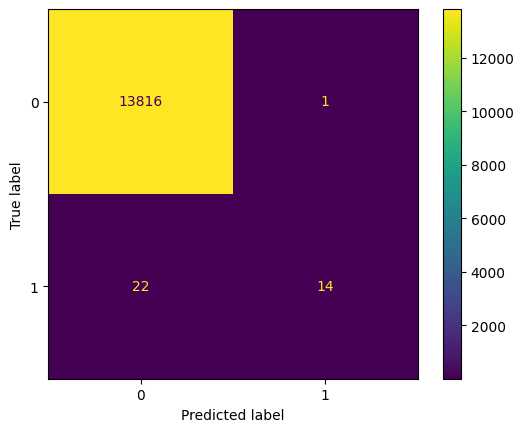

In [28]:
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_lr.classes_)
disp.plot()

### Naive bayes

In [31]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_tfidf, y_train)
y_pred_nb = clf_nb.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_nb))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.00      0.00      0.00        36

    accuracy                           1.00     13853
   macro avg       0.50      0.50      0.50     13853
weighted avg       0.99      1.00      1.00     13853



c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Paulo Seixal\OneDrive - Universidade do Minho\Bioinfo\Projeto\datasets\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

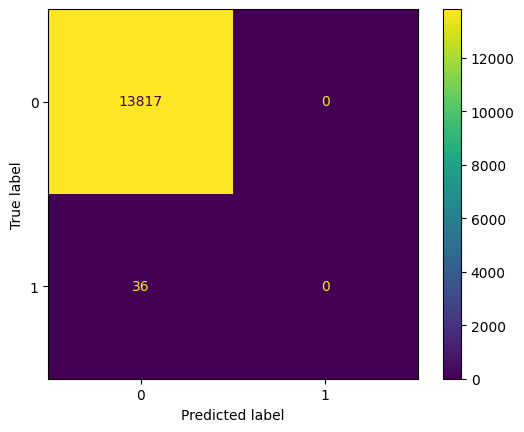

In [86]:
cm = confusion_matrix(y_test, y_pred_nb, labels=clf_nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_nb.classes_)
disp.plot()

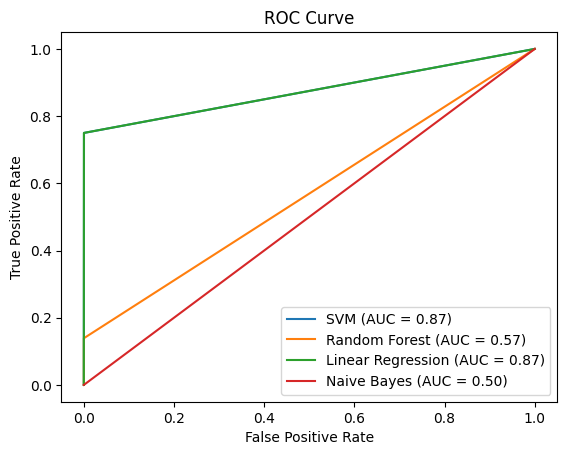

In [156]:
# Compute ROC curve and ROC area for each classifier
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_svm)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_rf)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_lr)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_nb)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

# Plot ROC curves
plt.plot(fpr1, tpr1, label='SVM (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Random Forest (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Linear Regression (AUC = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='Naive Bayes (AUC = %0.2f)' % roc_auc4)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

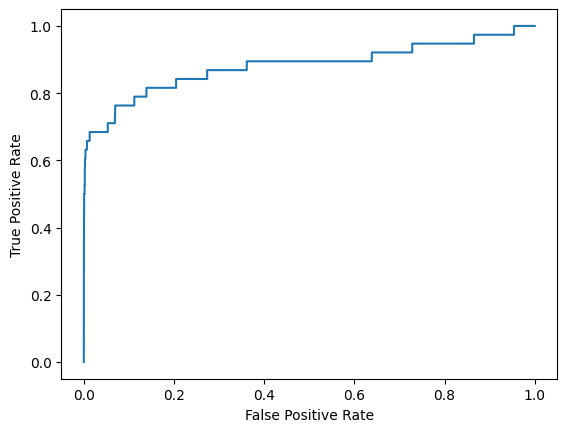

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

y_score = clf_svm.decision_function(X_test_tfidf)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf_svm.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

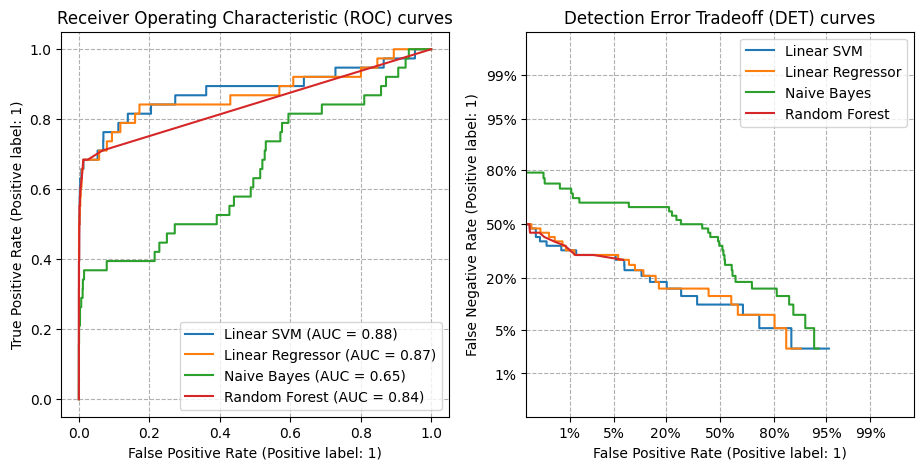

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

classifiers = {
    "Linear SVM": clf_svm,
    "Linear Regressor": clf_lr,
    'Naive Bayes': clf_nb,
    'Random Forest': clf_rf
}

import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)

    RocCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test_tfidf, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

### Ensemble

In [298]:
eclf = VotingClassifier(estimators=[('svm', clf_svm), ('lr', clf_lr)],
                        voting='hard', weights=[2,4])
eclf.fit(X_train_tfidf,y_train)
y_eclf_pred = eclf.predict(X_test_tfidf)
print(classification_report(y_test, y_eclf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.90      0.75      0.82        36

    accuracy                           1.00     13853
   macro avg       0.95      0.87      0.91     13853
weighted avg       1.00      1.00      1.00     13853



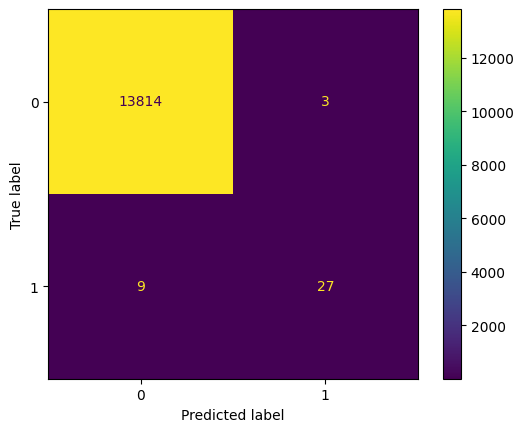

In [300]:
cm = confusion_matrix(y_test, y_eclf_pred, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

### MPLClassifier

In [301]:
clf_mpl = MLPClassifier()
clf_mpl.fit(X_train_tfidf, y_train)
y_pred_mlp = clf_mpl.predict(X_test_tfidf)

print('Classification Report')
print(classification_report(y_test,y_pred_mlp))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13817
           1       0.95      0.53      0.68        36

    accuracy                           1.00     13853
   macro avg       0.97      0.76      0.84     13853
weighted avg       1.00      1.00      1.00     13853



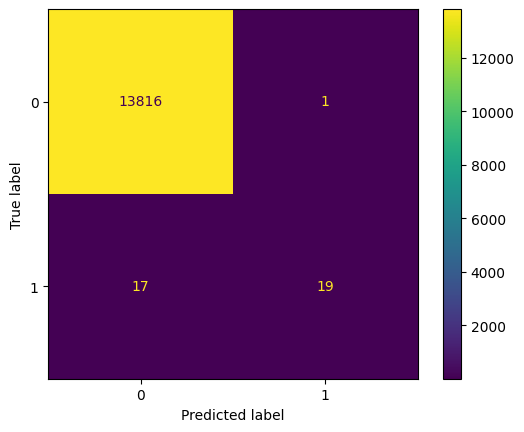

In [302]:
cm = confusion_matrix(y_test, y_pred_mlp, labels=clf_mpl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_mpl.classes_)
disp.plot()

In [303]:
print("Valores previstos: ", list(y_pred_mlp))
print("Valores reais: " , list(y_test))
score = 0
for x,y in zip(list(y_pred_mlp), list(y_test)):
    score +=1
    if x != y:
        print(score)

Valores previstos:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0